# Batch analysis across mice & regions

In [6]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [28]:
# External packages
import logging
import os

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Parameters

In [29]:
# Mouse line
mouseline = 'line3'

### Load data

In [30]:
logger.info('loading data:')
dataroot = get_data_root()
data_dir = os.path.join(dataroot, mouseline)
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
processed_dir = get_output_equivalent(data_dir, 'raw', 'processed')
trialavg_dir = get_output_equivalent(data_dir, 'raw', 'trial-averaged')
data = load_mousereg_datasets(trialavg_dir)
timeseries = data['timeseries']
stats = data['stats']
stats

 13/05/2022 14:01:06: loading data:
 13/05/2022 14:01:06: loading timeseries data from timeseries_mouse1_region1.csv
 13/05/2022 14:01:08: loading timeseries data from timeseries_mouse1_region2.csv
 13/05/2022 14:01:08: loading timeseries data from timeseries_mouse6_region1.csv
 13/05/2022 14:01:09: loading timeseries data from timeseries_mouse6_region2.csv
 13/05/2022 14:01:09: loading timeseries data from timeseries_mouse7_region1.csv
 13/05/2022 14:01:10: loading timeseries data from timeseries_mouse7_region2.csv
 13/05/2022 14:01:11: loading timeseries data from timeseries_mouse9_region1.csv
 13/05/2022 14:01:11: loading timeseries data from timeseries_mouse9_region2.csv
 13/05/2022 14:01:12: loading timeseries data from timeseries_mouse10_region1.csv
 13/05/2022 14:01:12: loading timeseries data from timeseries_mouse12_region1.csv
 13/05/2022 14:01:14: loading stats data from stats_mouse1_region1.csv
 13/05/2022 14:01:14: loading stats data from stats_mouse1_region2.csv
 13/05/202

line  trial_length  duration (s)   fps  P (MPa)  \
mouse_reg       ROI run                                                     
mouse10_region1 0   0    line3         100.0           0.2  3.56     0.00   
                    1    line3         100.0           0.2  3.56     0.10   
                    2    line3         100.0           0.2  3.56     0.20   
                    3    line3         100.0           0.2  3.56     0.40   
                    4    line3         100.0           0.2  3.56     0.05   
...                        ...           ...           ...   ...      ...   
mouse9_region2  690 10   line3         100.0           0.2  3.56     0.80   
                    11   line3         100.0           0.2  3.56     0.80   
                    12   line3         100.0           0.2  3.56     0.80   
                    13   line3         100.0           0.2  3.56     0.80   
                    14   line3         100.0           0.2  3.56     0.80   

                         DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
mouse_reg       ROI run                                                   
mouse10_region1 0   0      50.0   833.0        0.000000        0.000000   
                    1      50.0   831.0        0.309132        0.154566   
                    2      50.0   830.0        1.236530        0.618265   
                    3      50.0   829.0        4.946119        2.473059   
                    4      50.0   832.0        0.077283        0.038642   
...                         ...     ...             ...             ...   
mouse9_region2  690 10     40.0   903.0       19.784475        7.913790   
                    11     50.0   902.0       19.784475        9.892238   
                    12     60.0   908.0       19.784475       11.870685   
                    13     70.0   909.0       19.784475       13.849133   
                    14     80.0   910.0       19.784475       15.827580   

                         max pre-stim Z(ΔF/F0)  peak Z(ΔF/F0)  \
mouse_reg       ROI run                                         
mouse10_region1 0   0                 0.570601       0.279672   
                    1                 0.678398       3.630550   
                    2                 0.301746       1.118202   
                    3                 0.403354       1.265174   
                    4                 0.424186       0.725853   
...                                        ...            ...   
mouse9_region2  690 10                0.487581       0.190631   
                    11                0.608147       0.148890   
                    12                0.376397       0.096797   
                    13                0.479559       0.337685   
                    14                0.701365       0.598649   

                         baseline peak Z(ΔF/F0)  corrected peak Z(ΔF/F0)  \
mouse_reg       ROI run                                                    
mouse10_region1 0   0                  0.651163                -0.371490   
                    1                  1.192878                 2.437672   
                    2                  1.515949                -0.397747   
                    3                  0.432020                 0.833154   
                    4                  0.969651                -0.243797   
...                                         ...                      ...   
mouse9_region2  690 10                 0.190631                 0.000000   
                    11                 0.148890                 0.000000   
                    12                 0.099433                -0.002636   
                    13                 0.136711                 0.200974   
                    14                 0.127964                 0.470685   

                         positive condition?  # positive conditions  \
mouse_reg       ROI run                                               
mouse10_region1 0   0                  False                      7   


### Breakdown per mouse region

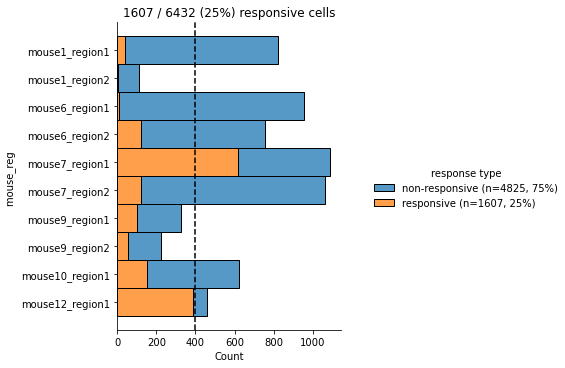

In [33]:
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=MIN_CELL_COUNT)

### Exclude datasets with low cell count

 13/05/2022 14:04:57: excluding ['mouse9_region2', 'mouse9_region1', 'mouse1_region2'] datasets from analysis


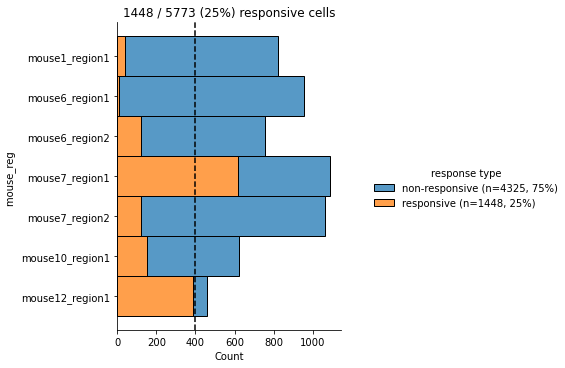

In [34]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.MOUSEREG, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.MOUSEREG).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < MIN_CELL_COUNT].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=MIN_CELL_COUNT)

## Parameter dependency curves

### Plotting function

In [129]:
def plot_paramsdeps(stats, ykey, stimparams=[Label.P, Label.DC], thr=None, nposthr=None, weighted=False, **kwargs):
    # Determine variable of interest for output metrics
    ykey_peak_corrected = f'corrected peak {ykey}'
    if thr is None:
        thr = {Label.ZSCORE: .5, Label.DFF: .05}[ykey]
    # Whether to perform averages weighted buy the respective number of ROIs in each dataset 
    if weighted == 'both':
        weighted = [True, False]
    else:
        weighted = [weighted]
    # Re-classify stats according to new criterion, if specified
    if thr is not None or nposthr is not None:
        stats = reclassify(stats.copy(), ykey_peak_corrected, thr=thr, nposthr=nposthr)
    # Plot parameter dependencies across cell types
    ybounds = {Label.ZSCORE: (None, 1.5), Label.DFF: None}[ykey]
    if not is_iterable(stimparams):
        stimparams = [stimparams]
    # def col_count_key(df):
    #     counts_by_type = len(df.groupby(
    #         [Label.MOUSEREG, Label.ROI]).first())
    #     print('c', counts_by_type, type(counts_by_type))
    #     return 'xx'
    for xkey in stimparams:
        for w in weighted:
            wstr = {True: '', False: 'non-'}[w] + 'weighted'
            fig = plot_parameter_dependency_across_datasets(
                stats, xkey, ykey_peak_corrected, weighted=w,
                baseline=[0., thr], ybounds=ybounds, 
                height=4, aspect=1., 
                hide_col_prefix=True, col_count_key=[Label.MOUSEREG, Label.ROI],
                **kwargs)
            if nposthr is not None:
                ttl = fig._suptitle.get_text()
                fig.suptitle(f'{ttl} (nposthr = {nposthr})')
            figs[f'{ykey_peak_corrected} vs {xkey} {wstr}'] = fig

### ΔF/F vs. Z(ΔF/F)

 13/05/2022 15:35:06: 5773 cells now organized as:
non-responsive    3288
responsive        2485
Name: response type, dtype: int64
 13/05/2022 15:35:06: sub-indexing data...
 13/05/2022 15:35:06: filtering data...
 13/05/2022 15:35:06: cross-checking filters...
 13/05/2022 15:35:06: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 13/05/2022 15:35:06: sub-indexing data...
 13/05/2022 15:35:06: filtering data...
 13/05/2022 15:35:06: cross-checking filters...
 13/05/2022 15:35:06: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. DC (%) ...


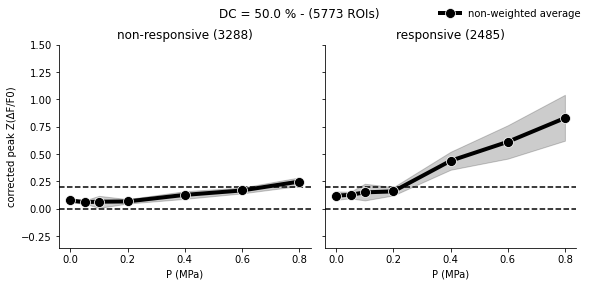

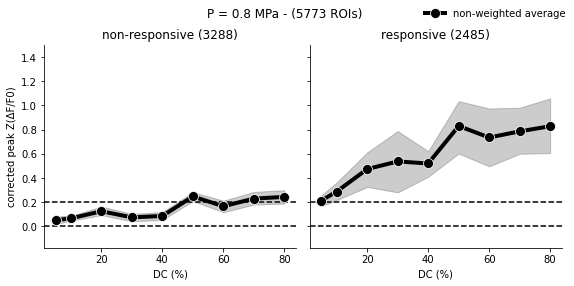

In [131]:
for ykey in [
    # Label.DFF,
    Label.ZSCORE
    ]:
    plot_paramsdeps(stats, ykey, thr=.2, show_datasets=False)

### Influence of detection threshold

 13/05/2022 15:35:11: 5773 cells now organized as:
responsive        5190
non-responsive     583
Name: response type, dtype: int64
 13/05/2022 15:35:11: sub-indexing data...
 13/05/2022 15:35:11: filtering data...
 13/05/2022 15:35:11: cross-checking filters...
 13/05/2022 15:35:11: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 13/05/2022 15:35:12: 5773 cells now organized as:
responsive        3944
non-responsive    1829
Name: response type, dtype: int64
 13/05/2022 15:35:12: sub-indexing data...
 13/05/2022 15:35:12: filtering data...
 13/05/2022 15:35:12: cross-checking filters...
 13/05/2022 15:35:12: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 13/05/2022 15:35:13: 5773 cells now organized as:
non-responsive    3065
responsive        2708
Name: response type, dtype: int64
 13/05/2022 15:35:13: sub-indexing data...
 13/05/2022 15:35:13: 

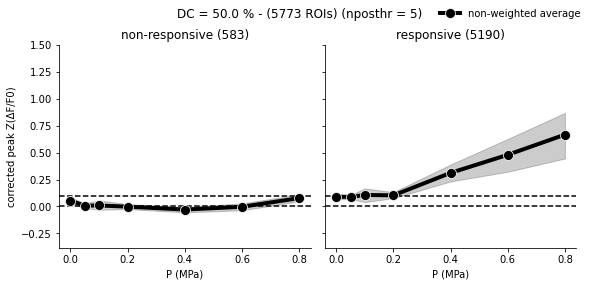

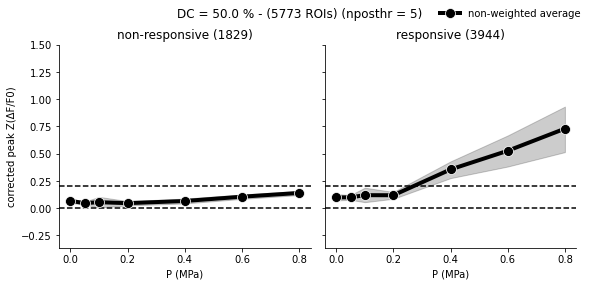

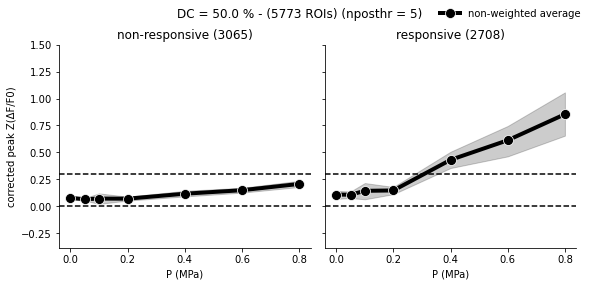

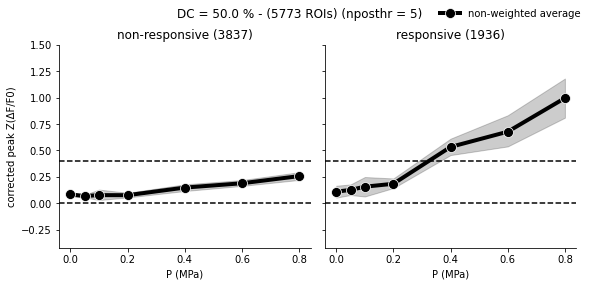

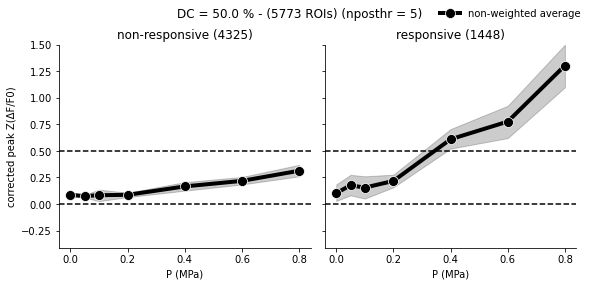

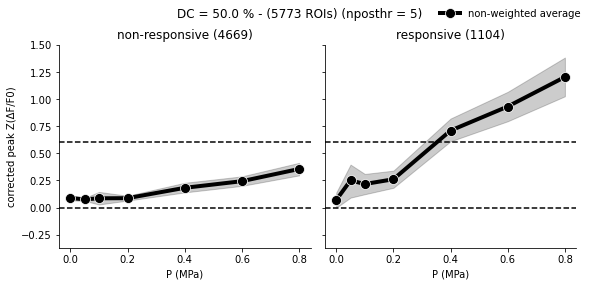

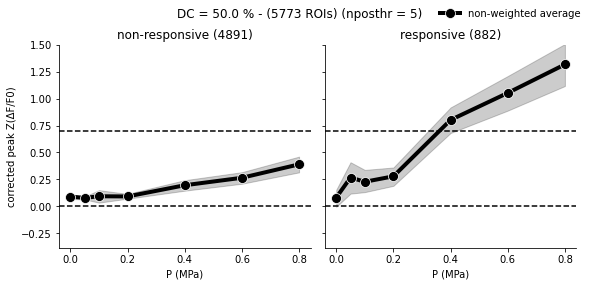

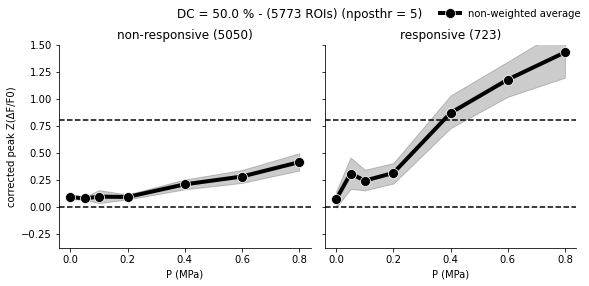

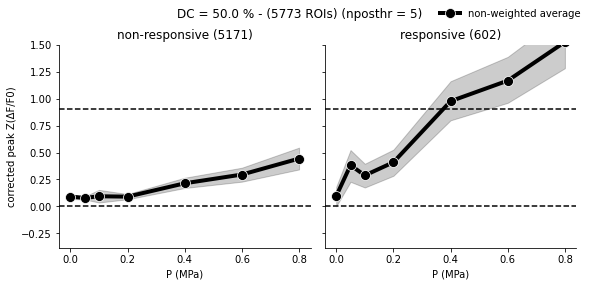

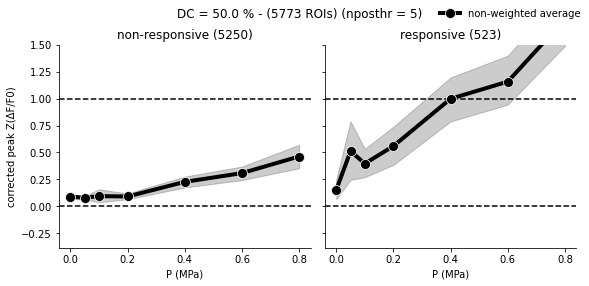

In [132]:
for t in np.linspace(.1, 1., 10):
    plot_paramsdeps(
        stats, Label.ZSCORE, stimparams=Label.P, thr=t, nposthr=5,
        show_datasets=False)

### Influence of threshold number of positive conditions

 13/05/2022 14:36:36: sub-indexing data...
 13/05/2022 14:36:36: filtering data...
 13/05/2022 14:36:36: cross-checking filters...
 13/05/2022 14:36:36: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 13/05/2022 14:36:37: sub-indexing data...
 13/05/2022 14:36:37: filtering data...
 13/05/2022 14:36:37: cross-checking filters...
 13/05/2022 14:36:37: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 13/05/2022 14:36:37: sub-indexing data...
 13/05/2022 14:36:37: filtering data...
 13/05/2022 14:36:37: cross-checking filters...
 13/05/2022 14:36:37: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 13/05/2022 14:36:38: sub-indexing data...
 13/05/2022 14:36:38: filtering data...
 13/05/2022 14:36:38: cross-checking filters...
 13/05/2022 14:36:38: grouping by response type, groupin

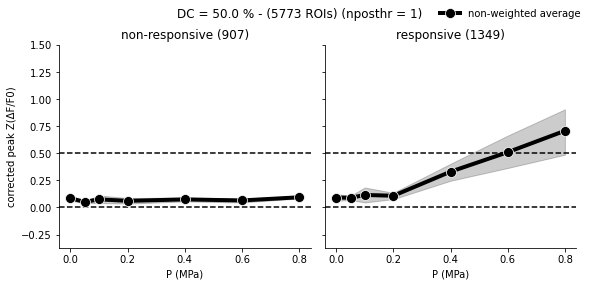

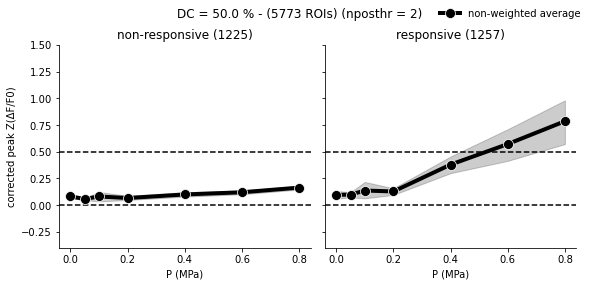

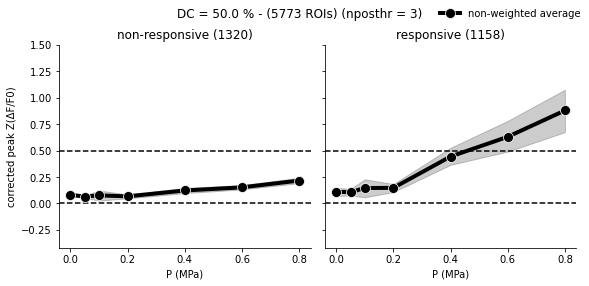

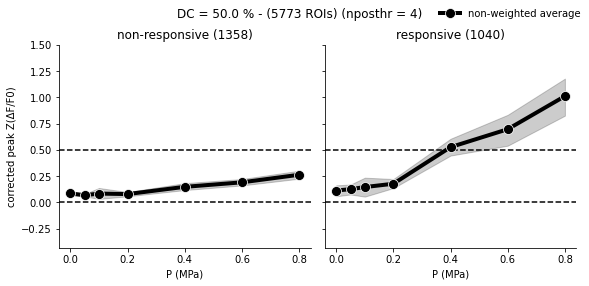

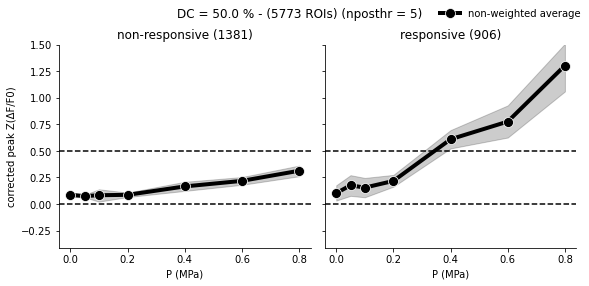

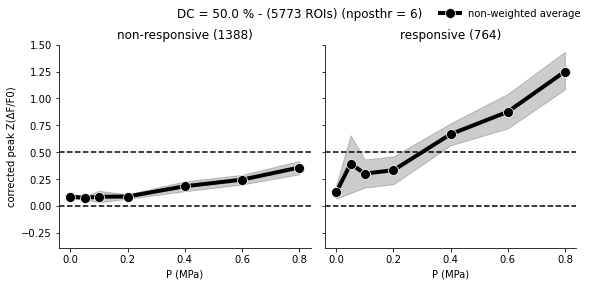

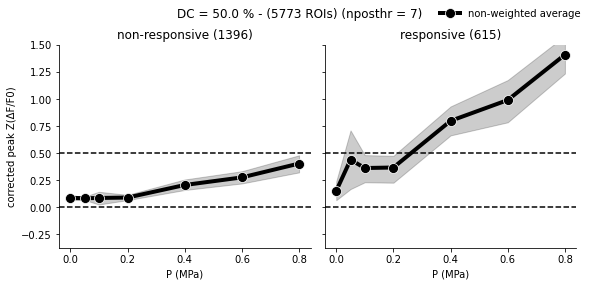

In [69]:
for n in np.arange(7) + 1:
    plot_paramsdeps(
        stats, Label.ZSCORE, stimparams=Label.P, thr=.5, nposthr=n,
        show_datasets=False)

## Traces

In [133]:
plt_data = get_plot_data(timeseries, stats)

 13/05/2022 15:36:02: merging timeseries and stats information...
 13/05/2022 15:36:26: adding time info to table...


 13/05/2022 15:36:35: plotting dependency curves for non-responsive cells...
 13/05/2022 15:36:35: sub-indexing data...
 13/05/2022 15:36:37: filtering data...
 13/05/2022 15:36:38: cross-checking filters...
 13/05/2022 15:36:38: grouping by mouse_reg, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...
 13/05/2022 15:37:24: plotting dependency curves for responsive cells...
 13/05/2022 15:37:24: sub-indexing data...
 13/05/2022 15:37:25: filtering data...
 13/05/2022 15:37:25: cross-checking filters...
 13/05/2022 15:37:25: grouping by mouse_reg, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...


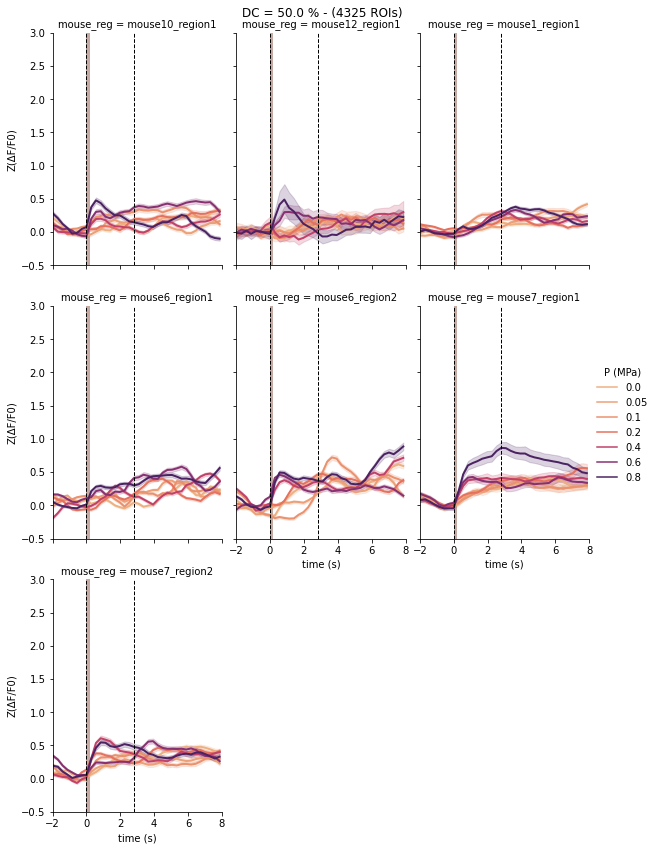

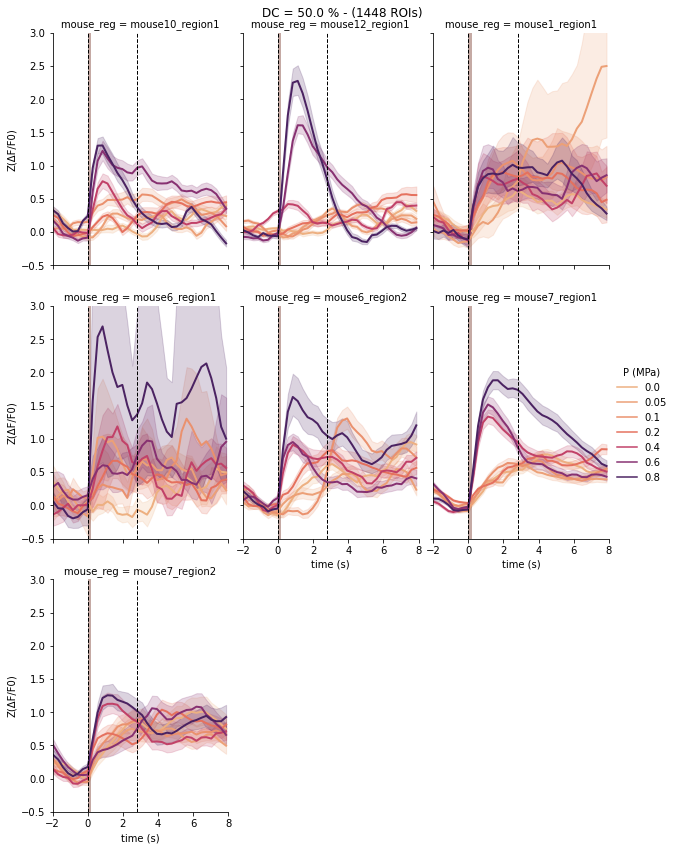

In [134]:
tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-.5, 3.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

for resptype, group in plt_data.groupby(Label.ROI_RESP_TYPE):
    logger.info(f'plotting dependency curves for {resptype} cells...')
    # Pressure dependency
    figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
        group, ykey=ykey, DC=DC_REF, hue=Label.P, 
        col=Label.MOUSEREG, max_colwrap=3, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

In [334]:
# Copy data and remove run index
avg_plt_data = plt_data.copy().droplevel(Label.RUN)
# Generate new run index from (P, DC) combination 
tmp1 = avg_plt_data[Label.P].map('{:.2f}MPa'.format)
tmp2 = avg_plt_data[Label.DC].map('{:.0f}%DC'.format)
avg_plt_data[Label.RUN] = tmp1 + tmp2
avg_plt_data.set_index(Label.RUN, append=True, inplace=True)
# Group data by mouse-region, response type, run and frame -> average
avg_plt_data = avg_plt_data.groupby(
    [Label.MOUSEREG, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR])

In [343]:
avg_plt_data2 = avg_plt_data.loc[:, [
    Label.P,
    Label.DC,
    Label.DUR,
    Label.TIME,
    Label.DFF,
    Label.ZSCORE
]]
avg_plt_data2

P (MPa)  DC (%)  \
mouse_reg       response type  run          frame                    
mouse10_region1 non-responsive 0.00MPa50%DC 0          0.0    50.0   
                                            1          0.0    50.0   
                                            2          0.0    50.0   
                                            3          0.0    50.0   
                                            4          0.0    50.0   
...                                                    ...     ...   
mouse7_region2  responsive     0.80MPa80%DC 95         0.8    80.0   
                                            96         0.8    80.0   
                                            97         0.8    80.0   
                                            98         0.8    80.0   
                                            99         0.8    80.0   

                                                   duration (s)   time (s)  \
mouse_reg       response type  run          frame                            
mouse10_region1 non-responsive 0.00MPa50%DC 0               0.2  -2.808989   
                                            1               0.2  -2.528090   
                                            2               0.2  -2.247191   
                                            3               0.2  -1.966292   
                                            4               0.2  -1.685393   
...                                                         ...        ...   
mouse7_region2  responsive     0.80MPa80%DC 95              0.2  23.876404   
                                            96              0.2  24.157303   
                                            97              0.2  24.438202   
                                            98              0.2  24.719101   
                                            99              0.2  25.000000   

                                                      ΔF/F0  Z(ΔF/F0)  
mouse_reg       response type  run          frame                      
mouse10_region1 non-responsive 0.00MPa50%DC 0      0.107019 -0.024015  
                                            1      0.115102  0.088903  
                                            2      0.122544  0.189725  
                                            3      0.121021  0.174803  
                                            4      0.116640  0.121139  
...                                                     ...       ...  
mouse7_region2  responsive     0.80MPa80%DC 95     0.164610  0.638125  
                                            96     0.165785  0.651761  
                                            97     0.163756  0.623942  
                                            98     0.160542  0.595325  
                                            99     0.157392  0.556107  

[21000 rows x 6 columns]

 10/05/2022 18:55:29: sub-indexing data...
 10/05/2022 18:55:29: filtering data...
 10/05/2022 18:55:29: cross-checking filters...
 10/05/2022 18:55:29: grouping by response type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


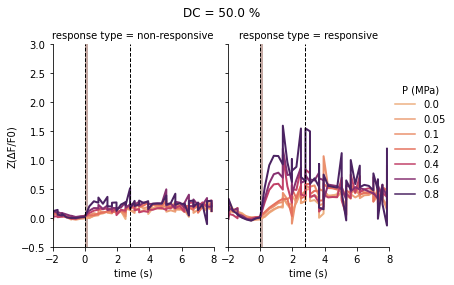

In [347]:
tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-.5, 3.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

# Pressure dependency
figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
    avg_plt_data2, ykey=ykey, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, ci=None, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

### Save figures

In [50]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix='global')

 10/05/2022 14:44:52: saving figure "rtype_dist_per_mousereg" on page 0
 10/05/2022 14:44:52: saving figure "relative Z(ΔF/F0) change vs P (MPa)" on page 1
